## Machine Learning for Stocks Trading
### Getting some historical data
Libraries or Modules:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date, time

try:
    import yfinance
except:
    !pip install -q yfinance
    import yfinance

try:
    import yahoofinancials
except:
    !pip install -q yahoofinancials
    import yahoofinancials

import yfinance as yf
from yahoofinancials import YahooFinancials

import warnings
warnings.filterwarnings("ignore")

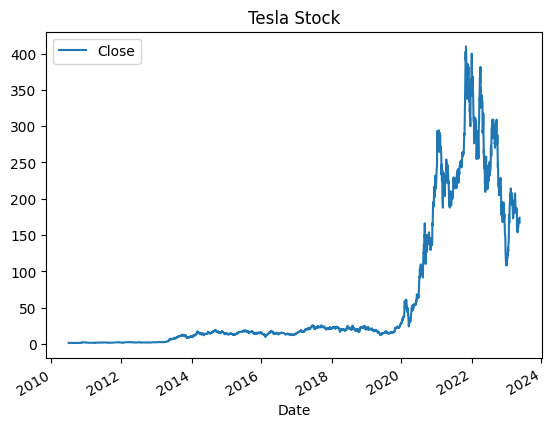

In [3]:
#Download Historical Data for tesla stock
df = yf.download('TSLA',
                start='2010-01-01',
                end=date.today(),
                progress=False,)
df.plot(y='Close', title='Tesla Stock')
plt.show()
    

### Create Technical Analysis Indicators and plot them

,Open,High,Low,Close,Adj Close,Volume,RSI(2),RSI(7),RSI(14),CCI(30),CCI(50),CCI(100)
Date,,,,,,,,,,,,
2010-11-17,2.013333,2.050000,1.907333,1.966000,1.966000,11250000,42.760531,69.700236,70.783665,150.212834,236.167196,362.534702
2010-11-18,2.044667,2.049333,1.928000,1.992667,1.992667,14341500,63.034012,71.443507,71.753149,137.781371,214.555090,345.275945
2010-11-19,2.010667,2.091333,1.980000,2.066000,2.066000,17257500,87.460641,75.893265,74.280617,138.690153,211.252585,361.454088
2010-11-22,2.104667,2.230000,2.100000,2.226667,2.226667,22945500,96.781036,82.759912,78.763949,160.222337,233.454931,403.225178
2010-11-23,2.219333,2.378667,2.146000,2.304667,2.304667,23667000,98.130358,85.154907,80.537681,164.201763,233.880206,405.588261


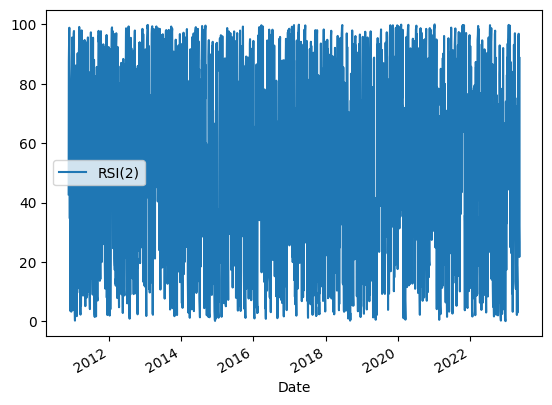

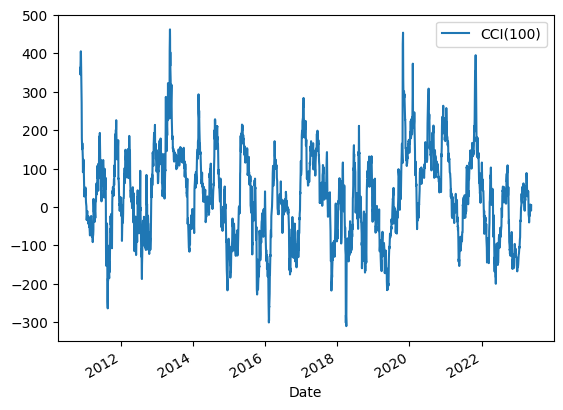

In [4]:
try:
    import pandas_ta as ta
except:
    !pip install -q pandas_ta
    import pandas_ta as ta

df['RSI(2)'] = ta.rsi(close=df['Close'], length=2)
df['RSI(7)'] = ta.rsi(close=df['Close'], length=7)
df['RSI(14)'] = ta.rsi(close=df['Close'], length=14)
df['CCI(30)'] = ta.cci(close=df['Close'], length=30,high=df['High'],low=df['Low'])
df['CCI(50)'] = ta.cci(close=df['Close'], length=50,high=df['High'],low=df['Low'])
df['CCI(100)'] = ta.cci(close=df['Close'], length=100,high=df['High'],low=df['Low'])

#Drop NaN Values
df = df.dropna()
#Create a plot showing some of our indicators
df.plot(y='RSI(2)')
df.plot(y='CCI(100)')
#How's our current dataframe going
df.head()

### Prepare our data labelling 
What do we want to do over here?\
When we place our trade: Buy at Open(over the next day)\
We want to close our trade: At the next day at open.

Formula:\
Handling the returns this ways:Buy:Open(-1)-Closing:Open(-2)\
We want to label our data in the following day.\
BUY SIGNAL: Open(-2) > Open(-1)\
SELL SIGNAL: Open(-2) < Open(-1)\
Indicators the current situations, and our labels take a look ahead of time to determine if we have a pattern.

In [5]:
import numpy as np
df['LABEL']= np.where(df['Open'].shift(-2).gt(df['Open'].shift(-1)),"1","0")
df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume,RSI(2),RSI(7),RSI(14),CCI(30),CCI(50),CCI(100),LABEL
Date,,,,,,,,,,,,,
2010-11-17,2.013333,2.050000,1.907333,1.966000,1.966000,11250000,42.760531,69.700236,70.783665,150.212834,236.167196,362.534702,0
2010-11-18,2.044667,2.049333,1.928000,1.992667,1.992667,14341500,63.034012,71.443507,71.753149,137.781371,214.555090,345.275945,1
2010-11-19,2.010667,2.091333,1.980000,2.066000,2.066000,17257500,87.460641,75.893265,74.280617,138.690153,211.252585,361.454088,1
2010-11-22,2.104667,2.230000,2.100000,2.226667,2.226667,22945500,96.781036,82.759912,78.763949,160.222337,233.454931,403.225178,1
2010-11-23,2.219333,2.378667,2.146000,2.304667,2.304667,23667000,98.130358,85.154907,80.537681,164.201763,233.880206,405.588261,1


### Training our neural network

In [6]:
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

#Fitting - Indicators and our Leablling
x = df[df.columns[6:-1]]
y = df["LABEL"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3) 

mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=1000)
mlp.fit(x_train,y_train)
predict_train = mlp.predict(x_train)
predict_test = mlp.predict(x_test)

from sklearn.metrics import classification_report, confusion_matrix

print('Train Data Accuracy')
print(classification_report(y_train,predict_train))

print('Testing Data Accuracy')
print(classification_report(y_test,predict_test))

Train Data Accuracy
              precision    recall  f1-score   support

           0       0.50      0.22      0.31      1064
           1       0.52      0.79      0.63      1137

    accuracy                           0.52      2201
   macro avg       0.51      0.51      0.47      2201
weighted avg       0.51      0.52      0.47      2201

Testing Data Accuracy
              precision    recall  f1-score   support

           0       0.47      0.23      0.31       452
           1       0.52      0.77      0.62       492

    accuracy                           0.51       944
   macro avg       0.50      0.50      0.46       944
weighted avg       0.50      0.51      0.47       944



### Backtesting our Model
#### Measure the returns obtained by trading our model


[]

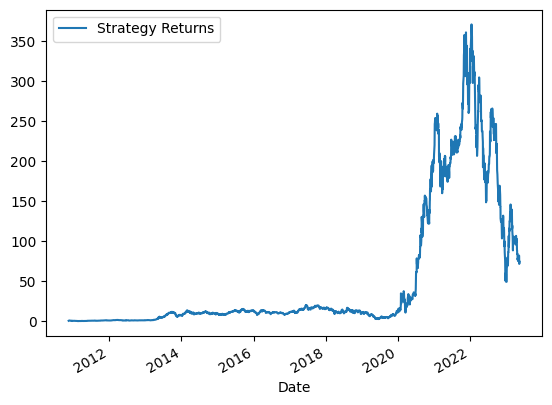

In [7]:
df['Prediction'] = np.append(predict_train,predict_test)
df['Strategy Returns'] = np.where(df['Prediction'].eq("1"),df['Open'].shift(-2)-df['Open'].shift(-1),0)
df['Strategy Returns'] = df['Strategy Returns'].cumsum()

df.plot(y='Strategy Returns')
plt.plot()

### Forecasting our returns

In [8]:
prediction = df.iloc[-1]['Prediction']

if prediction=="1":
    print("Today's return forecast: UP")
else:
    print("Today's return forecast: DOWN")

Today's return forecast: UP
